# Lab 2 - introducing Practical Modelling in Keras
  <a target="_blank" href="https://colab.research.google.com/github/andrew-nash/CS6421-labs-2025/blob/main/CS6421_Lab_02.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [353]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Tensors (https://www.tensorflow.org/guide/basics)

The basic data structure in TensorFlow is the tf.Tensor, which is very similar to the np.array

In [325]:
x = tf.constant([
    [1., 2., 3.],
    [4., 5., 6.]
    ])

vx = tf.Variable([
    [1., 2., 3.],
    [4., 5., 6.]
    ])

In [326]:
x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [327]:
vx

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

## Mathematical operations

These can be performed in much the same way as NumPy

In [328]:
x = tf.constant(3.25, dtype=tf.float32)
x 
x * 2

<tf.Tensor: shape=(), dtype=float32, numpy=6.5>

In [329]:
vx

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [330]:
tf.exp(vx)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  2.7182817,   7.389056 ,  20.085537 ],
       [ 54.59815  , 148.41316  , 403.4288   ]], dtype=float32)>

In [331]:
A = tf.constant([[1,2,3],[4,5,6]])
B = tf.constant([[1,2,3,4],[5,6,7,8],[9,10,11,12]])

C = tf.matmul(A, B)
C

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[ 38,  44,  50,  56],
       [ 83,  98, 113, 128]], dtype=int32)>

In [332]:
C.shape

TensorShape([2, 4])

## Auto-differentiation

One of the most imporant differces over NumPy is TensorFlow's ability to autmatically differentiate user-defined functions

In [333]:
def f(x):
    return x**2 + 2*x - 5

In [334]:
x = tf.Variable(2.0)

with tf.GradientTape() as tape:
    y = f(x)
  
g_x = tape.gradient(y, x)
g_x


<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

This also works over multi-variate functions

In [335]:
def f2(x):
    # y = 5*x + 2*exp(x)
    return tf.add(tf.multiply(x, tf.constant(5.0)), tf.multiply(tf.constant(2.0), tf.exp(x)))

In [336]:
x = tf.Variable([1.0,2.0,3.0,4.0,5.0])
with tf.GradientTape() as tape:
    y = f2(x)

g_x = tape.gradient(y, x)
g_x

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 10.4365635,  19.778112 ,  45.171074 , 114.1963   , 301.82632  ],
      dtype=float32)>

These are the tools that will allow us to implement our own layers, activation functions and loss functions to add to Keras models.

# Data Loading And Cleaning

For this lab, we will use a pre-loaded dataset from TensorFlow - the MNIST (Modified NIST) dataset. This is a set of 70,000 28x28 greyscale images, with associated labels, of handwritten digits (0-9).

In this case TensorFlow has already split up the dataset to give us 60k images for training, and a separate 10k for evaluation.

In [337]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0


**QUESTION** - why bother dividing the data by 255?

We will revisit this later in the lab.

In [338]:
print("Train shape", x_train.shape)
print("Test shape",  x_test.shape)

Train shape (60000, 28, 28)
Test shape (10000, 28, 28)


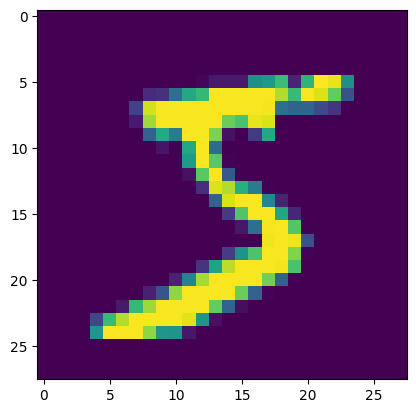

In [339]:
plt.imshow(x_train[0])

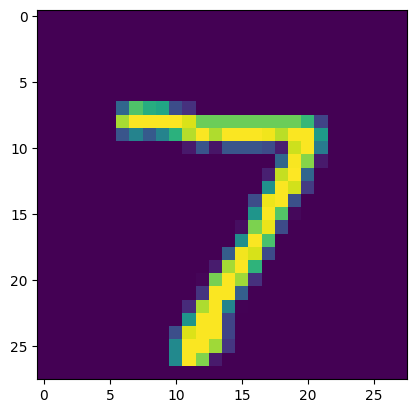

In [340]:
plt.imshow(x_test[0])

**EXERCISE**: Currently, `x_train` and `x_test` are arrays of square 28x28 images. For today, we are not going to be working with image-specific architectures and instead will pass our inputs as 784-length vectors instead of 28x28 images.

Use NumPy to transform `x_train` and `x_test` accordingly


In [341]:
x_train.shape

(60000, 28, 28)

In [342]:
x_train_clean = np.reshape(x_train, (x_train.shape[0], 784))
x_test_clean = np.reshape(x_test, (x_test.shape[0], 784))

Now lets consider our output labels.

In [343]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [344]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

`y_train` and `y_test` are simply arrays of numeric labels from 0-9.

Is this categorical, or quantitative data? Is there an inherent ordering to the values?

Therefore, is this the best possible data encoding for us to directly predict?

### One-hot Encoding

This is a more computer-friendly way of encoding categorical data.

The idea is, if there are $K$ possible values of our data, we represent each value as a vector of length $K$. One value of this vector is 1, while the rest remain 0.

E.g., if we want to encode a persons blood group (which is one of AB+, AB-, A+, A-, B+, B-, O+, O-) we could do the following:

Type | Encoded Vector |
---- | ----  |
AB+ | [1,0,0,0,0,0,0,0]
AB- | [0,1,0,0,0,0,0,0]
A+ | [0,0,1,0,0,0,0,0]
A- | [0,0,0,1,0,0,0,0]
B+ | [0,0,0,0,1,0,0,0]
B- | [0,0,0,0,0,1,0,0]
O+ | [0,0,0,0,0,0,1,0]
O- | [0,0,0,0,0,0,0,1]

The code to perform this transformation in tensorflow is simple.

In our case, because our data consists of the numbers 0-9, we can let our raw labels be the indices of the '1' value in the one-hot encoding.

I.e.

Type | Encoded Vector |
---- | ----  |
0 | [1,0,0,0,0,0,0,0,0,0]
1 | [0,1,0,0,0,0,0,0,0,0]
2 | [0,0,1,0,0,0,0,0,0,0]
3 | [0,0,0,1,0,0,0,0,0,0]
4 | [0,0,0,0,1,0,0,0,0,0]
5 | [0,0,0,0,0,1,0,0,0,0]
6 | [0,0,0,0,0,0,1,0,0,0]
7 | [0,0,0,0,0,0,0,1,0,0]
8 | [0,0,0,0,0,0,0,0,1,0]
9 | [0,0,0,0,0,0,0,0,0,1]

In [345]:
y_train_clean = tf.one_hot(indices=y_train, depth=10)
y_test_clean = tf.one_hot(indices=y_test, depth=10)

It is important to note that if your labels do not consist of the integers $0,1,2,3,4,\dots$ additional processing will be required to produce the one-hot vectors

## Model Design Process

We will now step through the process described to you in the lectures so far

1. Define Model
2. Compile Model
3. Train Model
4. Save Model (optional)
5. Save Best Weights (optional)
6. Evaluate Model
7. Predict using saved Model

### Define Model

In Keras, there are two main methods of defining a model - the Sequential API or the Functional API.

The Functional API has greater capability, at the price of extra code complexity. For now, we will focus on the Sequential API and introduce the functional API only once we introduce more complex models.

Sequential models are defined in a striaightforward layer-by-layer basis.

It is possible to implement your own type of layer, or use a pre-defined one from Keras' comprehensive list at https://www.tensorflow.org/api_docs/python/tf/keras/layers

It is critical to define the input and output shapes correctly - in this case our inputs are 784 length vectors, and our ouputs are vectors of length 10.

In [315]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(784,)))
model.add(tf.keras.layers.Dense(10))

**Pay attention** to the trailing comma after 784 - this is needed when our shape is a single value

In [316]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

This is the simplest possible model - with no activation function, and just one weight matrix and bias vector.

### Compile Model

This is where we specify our training hyper-parameters.

If you wish, you can define your own functions using tensorflow operations for any of these. Keras includes a library of loss functons, metrics and optimizers at:

https://www.tensorflow.org/api_docs/python/tf/keras/losses

https://www.tensorflow.org/api_docs/python/tf/keras/metrics

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [317]:
model.compile(
    optimizer= "SGD",
    loss = "mean_squared_error",
    metrics = ["accuracy"]
)

### Train Model

In [318]:
x_test_clean.shape

(10000, 784)

In [319]:
model.fit(
    x_train_clean,
    y_train_clean,
    epochs=5,
    batch_size = 128,
    validation_data = (x_test_clean,y_test_clean)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.2709 - loss: 0.1545 - val_accuracy: 0.5645 - val_loss: 0.0878
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.5817 - loss: 0.0844 - val_accuracy: 0.6672 - val_loss: 0.0723
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.6696 - loss: 0.0716 - val_accuracy: 0.7180 - val_loss: 0.0649
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7196 - loss: 0.0648 - val_accuracy: 0.7472 - val_loss: 0.0604
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7454 - loss: 0.0608 - val_accuracy: 0.7676 - val_loss: 0.0574


### Save Model

It is critically important to pick meaninful, and unique names for each model you train - and keep track of what saved model corresponsed to what training run.

In [320]:
model.save("simple_model_def_op_no_act.keras")

### Evaluate Model

In [321]:
model = tf.keras.models.load_model("simple_model_def_op_no_act.keras")
model.evaluate(x_test_clean, y_test_clean)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.7325 - loss: 0.0606


[0.057370591908693314, 0.7675999999046326]

### Predict Using Saved Model

**EXERCISE** Get the first image out of x_test_clean. Make sure its shape is (1,784) and not just (784).

In [346]:
datapoint = x_test_clean[0].reshape(1, 784)
model(datapoint)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.09092485,  0.0212313 ,  0.06347112, -0.02390962, -0.03296297,
        -0.07960513,  0.03362428,  0.693487  , -0.07357356,  0.00824115]],
      dtype=float32)>

## Model Architecture Improvements

Clearly, this simple model could use some improvement.

We can add:

1. Additional layers
2. Activation Functions
3. Regularization (Dropout and BatchNorm)



In [348]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(784,)))
model.add(tf.keras.layers.Dense(128, activation="sigmoid"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [349]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,282 (399.54 KB)

 Trainable params: 102,026 (398.54 KB)

 Non-trainable params: 256 (1.00 KB)

We can also choose a more appropiate optimizer and loss function for this particular case.

In [350]:
model.compile(
    optimizer= "Adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [351]:
model.fit(
    x_train_clean,
    y_train_clean,
    epochs=5,
    batch_size = 128,
    validation_data = (x_test_clean,y_test_clean)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7351 - loss: 0.8392 - val_accuracy: 0.9255 - val_loss: 0.2625
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9146 - loss: 0.2909 - val_accuracy: 0.9463 - val_loss: 0.1833
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9346 - loss: 0.2190 - val_accuracy: 0.9572 - val_loss: 0.1463
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 0.1780 - val_accuracy: 0.9630 - val_loss: 0.1247
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9563 - loss: 0.1461 - val_accuracy: 0.9679 - val_loss: 0.1114


In [352]:
model.save("simple_model_def_op_no_act.keras")

# Hyper-parameter Optimzation

For simplicity, we will use the Keras tuner to partially automate this process (https://www.tensorflow.org/tutorials/keras/keras_tuner)

## Model Builder Function

The first step is to define a function over the hyper-parameters of interest, that returns the validation metrics.

We will then search over these arguments to find their optimal values.

It is good practice when tuning these hyper-parameters to not use the test dataset for tuning - we will perform a separate split on our training data, and evaluate on thetest dataset post-optimization

**IMPORTANT** If you are using Google colab, the results will not be saved, once your notebook times out everything will be discarded.

Download any files or details you don't want to lose immediately.

Below are the highest scoring hyper-parameters. Be sure to closely examine the TensorBoard metrics for a better understanding of performance.

# Optional (But Recommended) Practice - Not Graded

This practice is not graded, but praciticing this task will prove useful for completing assignment 1.

Using keras_tuner (the various methods like hp.Int() and hp.Choice() are documented at https://keras.io/keras_tuner/api/hyperparameters/), try optimize the different hyper-parameters above model architecture.

You do not have to perform all of the optimization in one single search.

Refer to Lecture L06 as a guide for what to target.